In [25]:
import numpy as np
import camb
from cosmology import Cosmology

import glass.shells
import glass.ext.camb


# cosmology for the simulation
h = 0.7 # H0 = 100 h km/s/Mpc -> h is unitless, defined so that h = 1 is H0 = 100 km/s/Mpc
Oc = 0.25 # omega_cdm
Ob = 0.05 # omega_baryon

# basic parameters of the simulation
lmax = 1000 # maximum multipole of the matter angular power spectrum

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both) 

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

# shells of 200 Mpc in comoving distance spacing
zb = glass.shells.distance_grid(cosmo, 0., 1., dx=200.)

# uniform matter weight function
# CAMB requires linear ramp for low redshifts
ws = glass.shells.tophat_windows(zb, weight=glass.ext.camb.camb_tophat_weight) 

# compute angular matter power spectra with CAMB
cls200 = glass.ext.camb.matter_cls(pars, lmax, ws)

#np.save('cls200.npy', cls200)

In [2]:
import matplotlib.pyplot as plt
plt.plot(ws[0].za, ws[0].wa)
plt.xlabel('Scale factor')
plt.ylabel('Redshift')

NameError: name 'ws' is not defined

In [12]:
cls.shape

(153, 1001)

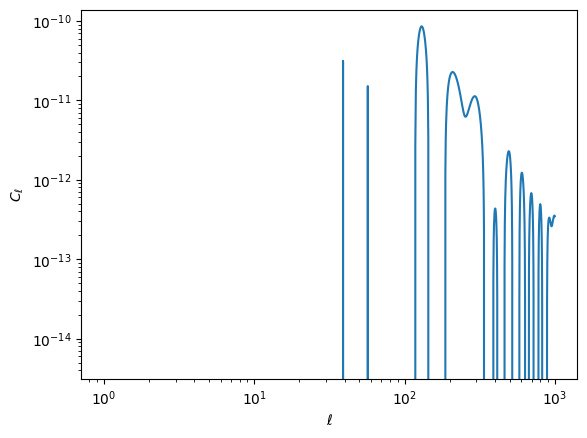

In [11]:
# Plot the matter power spectrum
cls = np.load('cls200.npy')
plt.plot(np.arange(1001), cls[30])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')
plt.show()

In [31]:
cls = np.load('cls.npy')

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Sample 2D array (replace this with your own data)
data = np.array(cls)

# Create a figure and axis
fig, ax = plt.subplots()

# Function to update the plot for each frame
def update(frame):
    ax.clear()  # Clear the previous plot
    ax.plot(np.arange(1001), data[data.shape[0]-frame - 1])  # Plot the current row

    # Set plot labels and title (customize as needed)
    ax.set_xlabel('$\ell$')
    ax.set_ylabel('$C_\ell$')
    ax.set_title('Shell {0}'.format(data.shape[0]-frame - 1))
    ax.set_ylim(1e-10, 1)
    ax.loglog()
    ax.set_title(f'Frame {frame + 1}/{data.shape[0]}')

# Create the animation
animation = FuncAnimation(fig, update, frames=data.shape[0], interval=100, repeat=False)
animation.save('glass_cls_100kpc.gif', writer='imagemagick')
plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# GLASS imports: matter, random fields, random points, galaxies
import glass.shells
import glass.fields
import glass.points
import glass.galaxies


# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = lmax = 128

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

# shells of 200 Mpc in comoving distance spacing
zb = glass.shells.distance_grid(cosmo, 0., 1., dx=200.)

# uniform matter weight function
ws = glass.shells.tophat_windows(zb)


# load the angular matter power spectra previously computed with CAMB
cls = np.load('cls200.npy')


In [21]:
cls500 = np.load('cls500.npy')

In [34]:
for i in range(cls.shape[0]):
    if cls[i].max() > 1e-6:
        print(i)

0
1
2
3
4
5
6
7
8
10
11
12
15
16
17
21
22
23
28
29
30
36
37
38
45
46
47
55
56
57
66
67
68
78
79
80
91
92
93
105
106
107
120
121
122
136
137
138
153
154
155
171
172
173
190
191
210
211
231
232
253
254
276
277
300
301
325
326
351
352
378
379
406
407
435
436
465
466
496
497
528
529
561
562


In [14]:
# compute Gaussian cls for lognormal fields for 3 correlated shells
gls = glass.fields.lognormal_gls(cls, nside=nside, lmax=lmax, ncorr=3)

# generator for lognormal matter fields
matter = glass.fields.generate_lognormal(gls, nside, ncorr=3)

In [15]:
# constant galaxy density distribution
z = np.linspace(0., 1., 100)
dndz = np.full_like(z, 0.01)

In [18]:
# make a cube for galaxy number in redshift
zcub = np.linspace(-zb[-1], zb[-1], 21)
cube = np.zeros((zcub.size-1,)*3)

# simulate and add galaxies in each matter shell to cube
for i, delta_i in enumerate(matter):

    # restrict galaxy distribution to this shell
    z_i, dndz_i = glass.shells.restrict(z, dndz, ws[i])

    # compute galaxy density in this shell
    ngal = np.trapz(dndz_i, z_i)

    # simulate positions from matter density
    for gal_lon, gal_lat, gal_count in glass.points.positions_from_delta(ngal, delta_i):

        # sample redshifts uniformly in shell
        gal_z = glass.galaxies.redshifts_from_nz(gal_count, ws[i].za, ws[i].wa)

        # add counts to cube
        z1 = gal_z*np.cos(np.deg2rad(gal_lon))*np.cos(np.deg2rad(gal_lat))
        z2 = gal_z*np.sin(np.deg2rad(gal_lon))*np.cos(np.deg2rad(gal_lat))
        z3 = gal_z*np.sin(np.deg2rad(gal_lat))
        (i, j, k), c = np.unique(np.searchsorted(zcub[1:], [z1, z2, z3]), axis=1, return_counts=True)
        cube[i, j, k] += c


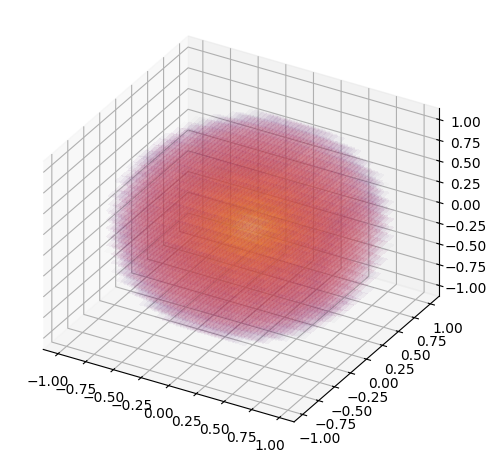

In [17]:
# positions of grid cells of the cube
z = (zcub[:-1] + zcub[1:])/2
z1, z2, z3 = np.meshgrid(z, z, z)

# plot the galaxy distribution in pseudo-3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')
norm = LogNorm(vmin=np.min(cube[cube > 0]), vmax=np.max(cube), clip=True)
for i in range(len(zcub)-1):
    v = norm(cube[..., i])
    c = plt.cm.inferno(v)
    c[..., -1] = 0.2*v
    ax.plot_surface(z1[..., i], z2[..., i], z3[..., i], rstride=1, cstride=1,
                    facecolors=c, linewidth=0, shade=False, antialiased=False)
fig.tight_layout()
plt.show()